In [ ]:
## This is the answer guide notebook 
## It has the un-modified data and good hyperparams

In [1]:
from sky_generator import SkyGeneratorTrue as SkyGenerator
from sky_generator import Eval

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dropout, Conv1D, Dense, AvgPool1D, Flatten
from tensorflow.keras.models import Model

import tensorflow as tf 
from sklearn.metrics import roc_curve, confusion_matrix

In [13]:
def make_model(): 
    in_layer = Input((28, 28))
    x = Conv1D(filters=4, kernel_size=2)(in_layer)
    x = Conv1D(filters=8, kernel_size=4)(x)
    x = Conv1D(filters=12, kernel_size=6)(x)
    
    x = AvgPool1D(6)(x)

    x = Conv1D(filters=4, kernel_size=2)(in_layer)
    x = Conv1D(filters=8, kernel_size=4)(x)
    x = Conv1D(filters=12, kernel_size=6)(x)
    
    x = AvgPool1D(6)(x)

    x = Flatten()(x)
    x = Dense(20, activation='relu')(x)

    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(in_layer, output)
    
    return model

model = make_model()
loss = tf.losses.BinaryCrossentropy()
model.compile(loss=loss, optimizer=tf.keras.optimizers.SGD(0.01))
model.summary()

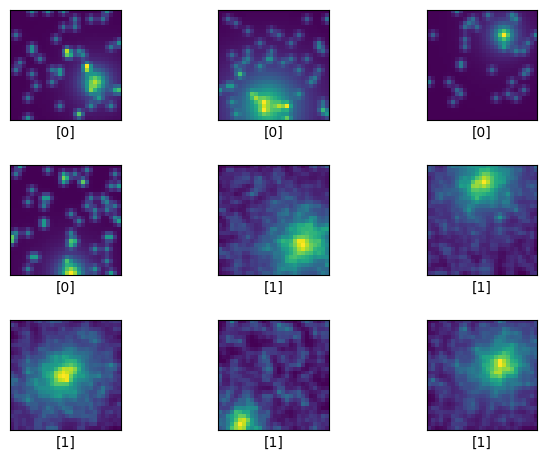

In [9]:
n_samples = 9
samples = SkyGenerator(n_samples=n_samples, batch_size=1) # Can just get a few samples

figure, subplots = plt.subplots(3, 3)
plt.tight_layout()
plt.setp(subplots, xticks=[], yticks=[])
for sample_index, subplot in zip(range(n_samples), subplots.ravel()): 
    image, label = samples[sample_index]
    subplot.imshow(image.squeeze())
    subplot.set_xlabel(label)


In [11]:
n_train_samples = 1280
train_generator = SkyGenerator(n_samples=n_train_samples, shuffle=True)

n_val_samples = 1280
val_generator = SkyGenerator(n_samples=n_val_samples, train=False, shuffle=True)

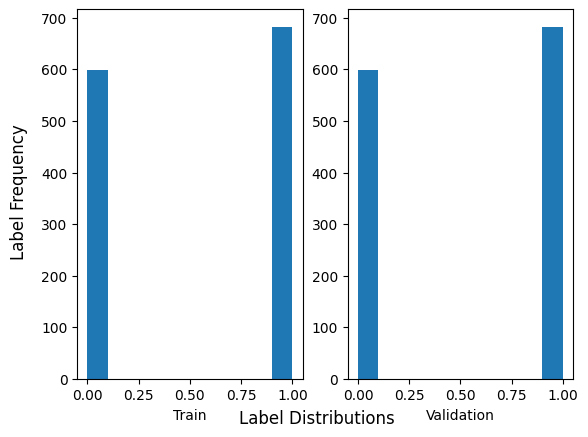

In [14]:
# We can look at the distribution of labels by grabbing them from the generator 
# TF.Sequence generators supply data as a tuple of (x,y) (or (features, labels)) - so using index 1 we can get the labels

all_train_labels = np.array([
    train_generator[i][1] for i in range(len(train_generator))
]).ravel()

all_val_labels = np.array([
    train_generator[i][1] for i in range(len(val_generator))
]).ravel()

figure, subplots = plt.subplots(1, 2)
subplots[0].hist(all_train_labels)
subplots[0].set_xlabel("Train")

subplots[1].hist(all_val_labels)
subplots[1].set_xlabel("Validation")

figure.supxlabel("Label Distributions")
figure.supylabel("Label Frequency")

plt.show()

In [21]:
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=50, 
    verbose=1
    ).history


Epoch 1/30
 1/20 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - loss: 0.6195

/Users/maggiev-local/miniforge3/envs/ss_tutorials/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.6076 - val_loss: 0.5701
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5673 - val_loss: 0.5366
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5396 - val_loss: 0.5231
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5254 - val_loss: 0.5012
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5044 - val_loss: 0.4774
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4924 - val_loss: 0.4669
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4752 - val_loss: 0.4485
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4387 - val_loss: 0.4282
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4453 - val_loss: 0.4083
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4181 - val_loss: 0.3877
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4160 - val_loss: 0.3807
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3850 - val_l

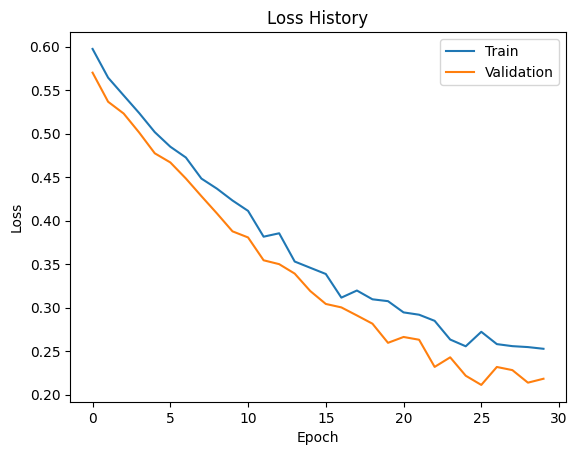

In [22]:
Eval.plot_history(history)

In [17]:
# Making a different testing set (So people can see the in-domain vs out-of-domain)

test_generator = SkyGenerator(n_samples=1280, train=False, shuffle=True)

def make_prediction(test_generator): 
    predictions = model.predict(test_generator)
    prediction_classes = np.where(predictions<0.5, 0, 1) # Challenge - make this backwards
    labels = test_generator.labels
    return prediction_classes, labels

def test_quality(prediction, labels): 
    accuracy = tf.keras.metrics.BinaryAccuracy()(prediction, labels)
    return accuracy.numpy()

prediction, labels = make_prediction(test_generator)

test_quality(prediction, labels)

In [ ]:
# Talk about the different types of eval 
# Show good and bad confusion matrix - Show exact labels. 
    # Embed 


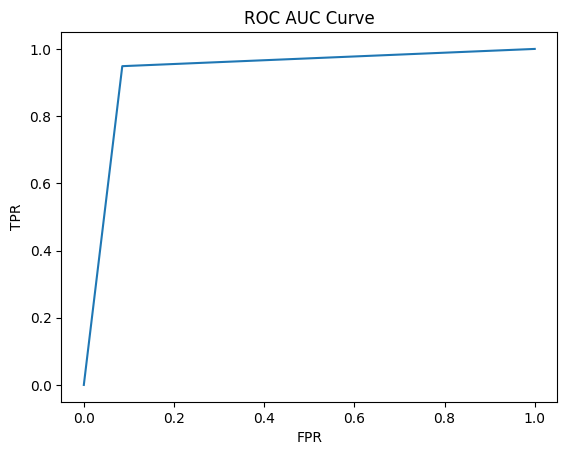

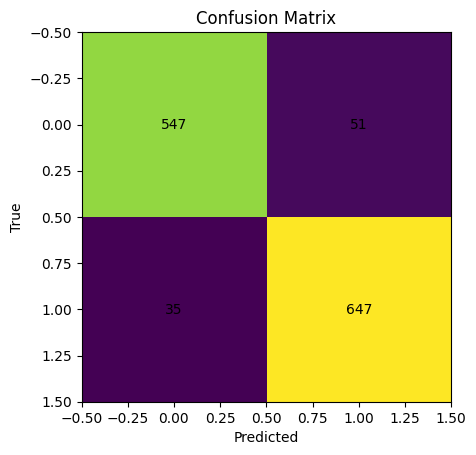

In [19]:
# Metrics and evaluation
Eval.ROC_curve(prediction, label)
Eval.confusion_matrix(prediction, label)